In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import generative" || pip install -q monai-generative
import tqdm
%matplotlib inline

In [14]:
import os
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.transforms import (
    EnsureChannelFirstd,
    CenterSpatialCropd,
    Compose,
    Lambdad,
    LoadImaged,
    Resized,
    ScaleIntensityd,
)
from monai.utils import set_determinism
from torch.cuda.amp import GradScaler, autocast
#from torch import GradScaler, autocast
from tqdm import tqdm

from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler, DDIMScheduler

print_config()

MONAI version: 1.3.0
Numpy version: 1.26.4
Pytorch version: 2.2.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /home/<username>/.conda/envs/monai/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.13
ITK version: 5.3.0
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.12.0
Pillow version: 10.2.0
Tensorboard version: 2.16.2
gdown version: 4.7.3
TorchVision version: 0.17.1+cu121
tqdm version: 4.66.2
lmdb version: 1.4.1
psutil version: 5.9.8
pandas version: 2.2.1
einops version: 0.7.0
transformers version: 4.38.2
mlflow version: 2.11.0
pynrrd version: 1.0.0
clearml version: 1.14.4

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
directory = "Generative"
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

Generative


In [4]:
set_determinism(42)
from util import pickOne
#def pickOne(x):
#   return x[:,:,:,1]

data_transform = Compose(
    [
        LoadImaged(keys=["image"]),
        Lambdad(keys="image", func=pickOne),
        EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        ScaleIntensityd(keys=["image"]),
        CenterSpatialCropd(keys=["image"], roi_size=[160, 200, 155]),
        Resized(keys=["image"], spatial_size=(32, 40, 32)),
    ]
)

In [5]:
train_ds = DecathlonDataset(
    root_dir=root_dir, task="Task01_BrainTumour", transform=data_transform, section="training", download=True
)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4, persistent_workers=True)

val_ds = DecathlonDataset(
    root_dir=root_dir, task="Task01_BrainTumour", transform=data_transform, section="validation", download=True
)

val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=4, persistent_workers=True)

2024-03-04 15:28:06,439 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2024-03-04 15:28:06,443 - INFO - File exists: Generative/Task01_BrainTumour.tar, skipped downloading.
2024-03-04 15:28:06,445 - INFO - Non-empty folder exists in Generative/Task01_BrainTumour, skipped extracting.


Loading dataset: 100%|██████████| 388/388 [05:08<00:00,  1.26it/s]


2024-03-04 15:33:26,216 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2024-03-04 15:33:26,217 - INFO - File exists: Generative/Task01_BrainTumour.tar, skipped downloading.
2024-03-04 15:33:26,218 - INFO - Non-empty folder exists in Generative/Task01_BrainTumour, skipped extracting.


Loading dataset: 100%|██████████| 96/96 [01:16<00:00,  1.26it/s]


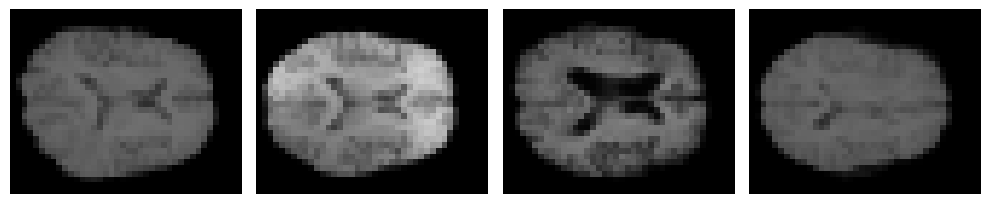

In [6]:
plt.subplots(1, 4, figsize=(10, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(train_ds[i * 20]["image"][0, :, :, 15].detach().cpu(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [7]:
device = torch.device("cpu")

model = DiffusionModelUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=[256, 256, 512],
    attention_levels=[False, False, True],
    num_head_channels=[0, 0, 512],
    num_res_blocks=2,
)
model.to(device)


DiffusionModelUNet(
  (conv_in): Convolution(
    (conv): Conv3d(1, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=256, out_features=1024, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock(
          (norm1): GroupNorm(32, 256, eps=1e-06, affine=True)
          (nonlinearity): SiLU()
          (conv1): Convolution(
            (conv): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          )
          (time_emb_proj): Linear(in_features=1024, out_features=256, bias=True)
          (norm2): GroupNorm(32, 256, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          )
          (skip_connection): Identity()
        )
  

In [8]:
scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0005, beta_end=0.0195)

Text(0, 0.5, 'alpha cumprod')

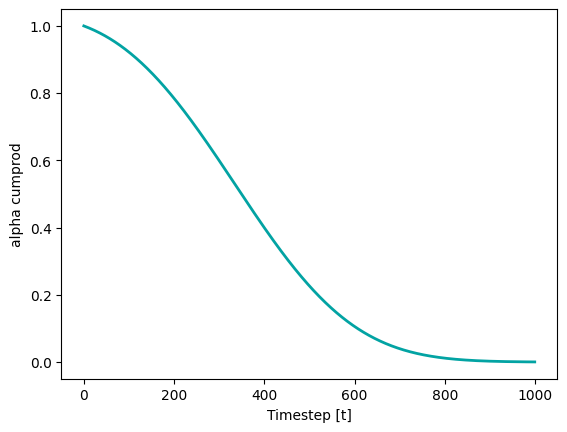

In [9]:
plt.plot(scheduler.alphas_cumprod.cpu(), color=(2 / 255, 163 / 255, 163 / 255), linewidth=2)
plt.xlabel("Timestep [t]")
plt.ylabel("alpha cumprod")

In [10]:
inferer = DiffusionInferer(scheduler)

optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-5)

In [17]:
n_epochs = 150  # 150
val_interval = 25  # 25
epoch_loss_list = []
val_epoch_loss_list = []
device = torch.device("cpu")

# Not needed on CPU
#scaler = GradScaler()

total_start = time.time()
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)  # because we switch off the GradScaler for CPU use we might want to change that (remove argument)

        with torch.autocast(device_type="cpu", enabled=True):
            # Generate random noise
            noise = torch.randn_like(images).to(device)

            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()

            # Get model prediction
            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)

            loss = F.mse_loss(noise_pred.float(), noise.float())

        # we need to do the backward pass and the optimizer step even if we do not use the scaler
        loss.backward()
        optimizer.step()
        # Not needed on CPU
        #scaler.scale(loss).backward()
        #scaler.step(optimizer)
        #scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        for step, batch in enumerate(val_loader):
            images = batch["image"].to(device)
            noise = torch.randn_like(images).to(device)
            with torch.no_grad():
                with torch.autocast(device_type="cpu", enabled=True):
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                    ).long()

                    # Get model prediction
                    noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()
            progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
        val_epoch_loss_list.append(val_epoch_loss / (step + 1))

        # Sampling image during training
        image = torch.randn((1, 1, 32, 40, 32))
        image = image.to(device)
        scheduler.set_timesteps(num_inference_steps=1000)
        with autocast(enabled=True):
            image = inferer.sample(input_noise=image, diffusion_model=model, scheduler=scheduler)

        plt.figure(figsize=(2, 2))
        plt.imshow(image[0, 0, :, :, 15].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

Epoch 0:  47%|█████▋      | 23/49 [31:44<33:15, 76.74s/it, loss=0.506]

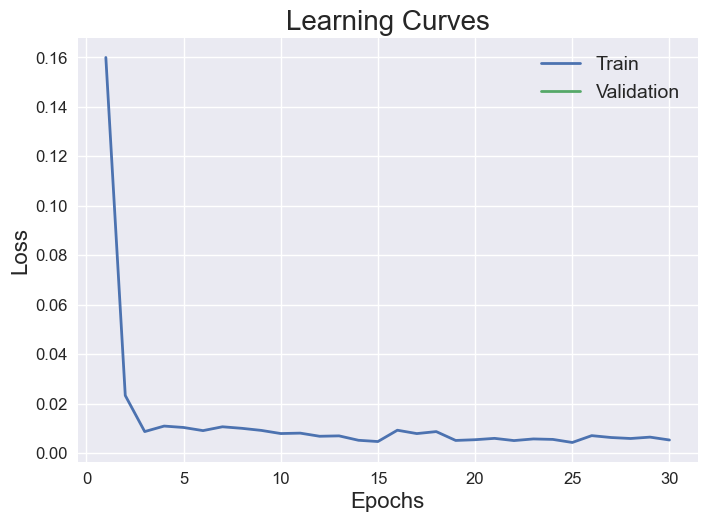

In [28]:
plt.style.use("seaborn-v0_8")
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_loss_list, color="C0", linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)),
    val_epoch_loss_list,
    color="C1",
    linewidth=2.0,
    label="Validation",
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

In [31]:
model.eval()
noise = torch.randn((1, 1, 32, 40, 32))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=1000)
image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

100%|██████████| 1000/1000 [1:54:51<00:00,  6.89s/it]


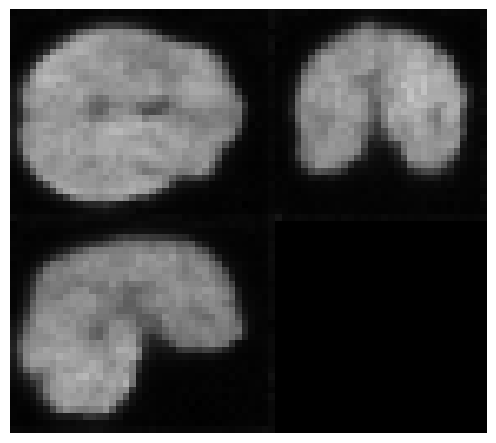

In [32]:
plt.style.use("default")
plotting_image_0 = np.concatenate([image[0, 0, :, :, 15].cpu(), np.flipud(image[0, 0, :, 20, :].cpu().T)], axis=1)
plotting_image_1 = np.concatenate([np.flipud(image[0, 0, 15, :, :].cpu().T), np.zeros((32, 32))], axis=1)
plt.imshow(np.concatenate([plotting_image_0, plotting_image_1], axis=0), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()